In [1]:
import os
import pandas
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import time
import texthero

from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn import metrics

import matplotlib.pyplot as plt
import ast
import statistics

import pickle
#import warnings;
#warnings.filterwarnings('ignore')

print(os.getcwd())

C:\Anaconda\lib\site-packages\spacy\util.py:730: UserWarning: [W095] Model 'en_core_web_sm' (3.0.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.1.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


C:\Users\João Fonseca\Desktop\ESS\Mestrado - Bioestatística e Bioinformática Aplicadas à Saúde\2º ano MBBAS\Modelos


In [2]:
#Import Público Dataset
publico = pandas.read_csv(filepath_or_buffer = 'Público.csv', 
                          sep = ',', header = 0, 
                          usecols = ['SAMPMATTEXT', 'text_clean_nostopwords', 'CODE_1'])

publico.columns = ['SAMPMATTEXT', 'SAMPTEXT', 'CODE_1']

#publico.head()
#pandas.DataFrame.head?

In [3]:
#Data Summary
publico.describe()

,SAMPMATTEXT,SAMPTEXT,CODE_1
count,700543,700543,700543
unique,3416,3367,929
top,"Sal, n.e.",sal n,A0BZ9
freq,44589,44589,48327


In [4]:
#FoodEx2 text_clean Processes:
from texthero import preprocessing as pp
from nltk.corpus import stopwords

custom_pipeline = [pp.lowercase,
                   pp.remove_digits,
                   pp.remove_punctuation,
                   pp.remove_diacritics]

publico['SAMPMATTEXT'] = pp.clean(publico['SAMPMATTEXT'], custom_pipeline)
publico['SAMPMATTEXT'] = pp.remove_stopwords(publico['SAMPMATTEXT'], stopwords.words('portuguese'))
publico['SAMPMATTEXT'] = pp.remove_whitespace(publico['SAMPMATTEXT'])
publico['SAMPMATTEXT'] = publico['SAMPMATTEXT'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))
publico['SAMPMATTEXT'] = pp.remove_whitespace(publico['SAMPMATTEXT'])

C:\Anaconda\lib\site-packages\texthero\preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
C:\Anaconda\lib\site-packages\texthero\preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)


In [ ]:
#Amostragem
f = 0.5
amostra = publico.sample(frac = f, random_state = 42)
amostra = amostra.reset_index(drop = True)
print(len(amostra))
print(len(pandas.Series.unique(amostra.loc[:, 'CODE_1'])))

In [ ]:
#Amostragem
f = 0.5
N = f * len(publico)
amostra = publico.groupby('CODE_1', group_keys=False).apply(lambda x: x.sample(int(np.rint(N*len(x)/len(publico))))).sample(frac=1).reset_index(drop=True)
print(len(amostra))
print(len(pandas.Series.unique(amostra.loc[:, 'CODE_1'])))

In [57]:
#Importar ASAE Dataset
asae_1 = pandas.read_csv(filepath_or_buffer = 'ASAE_1.csv', 
                         sep = ',', header = 0,
                        usecols = ['SAMPMATTEXT', 'text_clean_nostopwords', 'CODE_1'])

asae_1.columns = ['SAMPMATTEXT', 'SAMPTEXT', 'CODE_1']
#asae_1.head()

In [58]:
asae_1.describe()

,SAMPMATTEXT,SAMPTEXT,CODE_1
count,78157,78157,78157
unique,10746,9757,1574
top,Gallus gallus- frangos- antes do abate,gallus gallus frangos antes abate,A0C74
freq,11592,11592,26062


In [63]:
asae_1['CODE_1'].value_counts()[asae_1['CODE_1'].value_counts() > 1]

A0C74    26062
A0C60     6315
A01XJ     4846
A0F7L     3754
A04HG     2550
         ...  
A021J        2
A04FP        2
A04DT        2
A022G        2
A037K        2
Name: CODE_1, Length: 1048, dtype: int64

In [7]:
#Dividing Data and creating samples
#amostra = asae_1.sample(frac = 0.3)
amostra = publico

# how to define X and y (from the SMS data) for use with COUNTVECTORIZER
X = amostra.loc[:, 'SAMPMATTEXT']
y = amostra.loc[:, 'CODE_1']

del amostra
print(X.shape)
print(y.shape)

(700543,)
(700543,)


In [6]:
# split X and y into training and testing sets (Hold-out Validation)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 2/3, test_size = 1/3, random_state = 1)

del X, y

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(467028,)
(233515,)
(467028,)
(233515,)


In [8]:
#Vectorizing (BoW)
count_vect = CountVectorizer()
X_vec = count_vect.fit_transform(X)

#Vectorizing (TF-IDF)
tfidf_transformer = TfidfTransformer()
X_vec_tfidf = tfidf_transformer.fit_transform(X_vec)

In [11]:
print(X_vec_tfidf.shape)

(700543, 1679)


In [ ]:
#List of Evaluation Metrics
t_metrics = pandas.DataFrame(columns= ['model', 'size', 'accuracy', 'accuracy_balanced', 'recall_micro', 
                                       'precision_micro', 'recall_weighted', 'precision_weighted',
                                       'f1_weighted', 'f1_macro', 'f1_micro', 'time'])

#Size of Trainning Set
fracao = [0.5]

#Training Models

model = [AdaBoostClassifier]

line = 0
for i in model:
    
    print(str(i))
    
    for f in fracao:
        
        print(f)
        
        t_ac = []
        t_acb = []
        t_recall_micro = []
        t_precision_micro = []
        t_recall_weighted = []
        t_precision_weighted = []
        t_f1_weighted = []
        t_f1_macro = []
        t_f1_micro = []
        t_time = []
        
        '''
        #Remove Duplicates!!!!
         = .drop_duplicates(subset = ['CODE_1', 'SAMPMATTEXT'])
         = .reset_index(drop = True)
        '''
        
        #Dividing Data and creating samples
        amostra = asae_1.sample(frac = f, random_state = 42)
        amostra = amostra.reset_index(drop = True)
        
        X = amostra.loc[:, 'text_clean_nostopwords']
        y = amostra.loc[:, 'CODE_1']

        kf = KFold(n_splits = 10, shuffle = True, random_state = 42)

        for train_index, test_index in kf.split(X):
            #Creating Test and Train Sets
            #print('Train: ', train_index, 'Test: ', test_index)
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            #Vectorizing Train Set (BoW)
            count_vect = CountVectorizer()
            X_train_counts = count_vect.fit_transform(X_train)
            #Vectorizing Train Set (TF-IDF)
            tfidf_transformer = TfidfTransformer()
            X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

            #len(count_vect.get_feature_names())
            del X_train, X_train_counts

            #Vectorize Test set
            X_test_counts = count_vect.transform(X_test)
            X_test_tfidf = tfidf_transformer.transform(X_test_counts)

            del X_test, X_test_counts

            # import and instantiate models
            nb = i()

            # train the model using X_train_dtm
            start = time.time()
            nb.fit(X_train_tfidf, y_train)
            stop = time.time()

            # make class predictions for X_test_dtm
            y_pred_class = nb.predict(X_test_tfidf)
            
            #calculate metrics
            t_ac.append("%.3f" % round(metrics.accuracy_score(y_test, y_pred_class), 6))
            t_acb.append("%.3f" % round(metrics.balanced_accuracy_score(y_test, y_pred_class), 6))
            t_recall_micro.append("%.3f" % round(metrics.recall_score(y_test, y_pred_class, average = 'micro',zero_division = 0), 6))
            t_precision_micro.append("%.3f" % round(metrics.precision_score(y_test, y_pred_class, average = 'micro', zero_division = 0), 6))
            t_recall_weighted.append("%.3f" % round(metrics.recall_score(y_test, y_pred_class, average = 'weighted', zero_division = 0), 6))
            t_precision_weighted.append("%.3f" % round(metrics.precision_score(y_test, y_pred_class, average = 'weighted', zero_division = 0), 6))
            t_f1_weighted.append("%.3f" % round(metrics.f1_score(y_test, y_pred_class, average = 'weighted'), 6))
            t_f1_macro.append("%.3f" % round(metrics.f1_score(y_test, y_pred_class, average = 'macro'), 6))
            t_f1_micro.append("%.3f" % round(metrics.f1_score(y_test, y_pred_class, average = 'micro'), 6))
            t_time.append("%.3f" % round(stop - start, 6))
            
        #add metrics
        my_list = [' ', '<class', '>', "'"]
        s = str(i)
        
        for a in my_list:
            s = s.replace(a, '')
            
        t_metrics.loc[line, 'model'] = s
        t_metrics.loc[line, 'size'] = f
        t_metrics.loc[line, 'accuracy'] = t_ac
        t_metrics.loc[line, 'accuracy_balanced'] = t_acb
        t_metrics.loc[line, 'recall_micro'] = t_recall_micro
        t_metrics.loc[line, 'precision_micro'] = t_precision_micro
        t_metrics.loc[line, 'recall_weighted'] = t_recall_weighted
        t_metrics.loc[line, 'precision_weighted'] = t_precision_weighted
        t_metrics.loc[line, 'f1_weighted'] = t_f1_weighted
        t_metrics.loc[line, 'f1_macro'] = t_f1_macro
        t_metrics.loc[line, 'f1_micro'] = t_f1_micro
        t_metrics.loc[line, 'time'] = t_time
         
        line = line + 1

In [12]:
t_metrics.head()

,model,size,accuracy,accuracy_balanced,recall_micro,precision_micro,recall_weighted,precision_weighted,f1_weighted,f1_macro,f1_micro,time
0,sklearn.svm._classes.LinearSVC,0.1,"[0.893, 0.879, 0.907, 0.891, 0.905, 0.904, 0.9...","[0.601, 0.559, 0.649, 0.599, 0.641, 0.637, 0.6...","[0.893, 0.879, 0.907, 0.891, 0.905, 0.904, 0.9...","[0.893, 0.879, 0.907, 0.891, 0.905, 0.904, 0.9...","[0.893, 0.879, 0.907, 0.891, 0.905, 0.904, 0.9...","[0.888, 0.868, 0.908, 0.883, 0.899, 0.883, 0.8...","[0.886, 0.868, 0.903, 0.883, 0.898, 0.890, 0.8...","[0.464, 0.429, 0.507, 0.472, 0.522, 0.524, 0.4...","[0.893, 0.879, 0.907, 0.891, 0.905, 0.904, 0.9...","[3.221, 3.047, 3.146, 3.007, 3.235, 2.961, 3.4..."
1,sklearn.svm._classes.LinearSVC,0.2,"[0.928, 0.926, 0.922, 0.928, 0.931, 0.928, 0.9...","[0.673, 0.645, 0.654, 0.650, 0.677, 0.659, 0.7...","[0.928, 0.926, 0.922, 0.928, 0.931, 0.928, 0.9...","[0.928, 0.926, 0.922, 0.928, 0.931, 0.928, 0.9...","[0.928, 0.926, 0.922, 0.928, 0.931, 0.928, 0.9...","[0.931, 0.917, 0.918, 0.924, 0.926, 0.926, 0.9...","[0.926, 0.918, 0.916, 0.922, 0.926, 0.923, 0.9...","[0.548, 0.535, 0.535, 0.531, 0.568, 0.532, 0.5...","[0.928, 0.926, 0.922, 0.928, 0.931, 0.928, 0.9...","[8.956, 8.345, 7.928, 7.629, 7.840, 7.649, 7.7..."
2,sklearn.svm._classes.LinearSVC,0.3,"[0.929, 0.933, 0.945, 0.936, 0.933, 0.943, 0.9...","[0.641, 0.664, 0.705, 0.678, 0.670, 0.694, 0.6...","[0.929, 0.933, 0.945, 0.936, 0.933, 0.943, 0.9...","[0.929, 0.933, 0.945, 0.936, 0.933, 0.943, 0.9...","[0.929, 0.933, 0.945, 0.936, 0.933, 0.943, 0.9...","[0.928, 0.928, 0.942, 0.934, 0.931, 0.943, 0.9...","[0.924, 0.928, 0.940, 0.932, 0.927, 0.941, 0.9...","[0.526, 0.548, 0.592, 0.565, 0.560, 0.587, 0.5...","[0.929, 0.933, 0.945, 0.936, 0.933, 0.943, 0.9...","[13.495, 13.762, 13.642, 13.769, 13.983, 13.76..."
3,sklearn.svm._classes.LinearSVC,0.4,"[0.944, 0.949, 0.939, 0.948, 0.945, 0.944, 0.9...","[0.683, 0.695, 0.671, 0.681, 0.680, 0.699, 0.6...","[0.944, 0.949, 0.939, 0.948, 0.945, 0.944, 0.9...","[0.944, 0.949, 0.939, 0.948, 0.945, 0.944, 0.9...","[0.944, 0.949, 0.939, 0.948, 0.945, 0.944, 0.9...","[0.940, 0.945, 0.933, 0.947, 0.943, 0.942, 0.9...","[0.938, 0.945, 0.933, 0.944, 0.941, 0.939, 0.9...","[0.568, 0.601, 0.553, 0.574, 0.563, 0.585, 0.5...","[0.944, 0.949, 0.939, 0.948, 0.945, 0.944, 0.9...","[24.967, 23.556, 23.663, 23.772, 23.561, 24.09..."
4,sklearn.svm._classes.LinearSVC,0.5,"[0.950, 0.952, 0.951, 0.952, 0.947, 0.952, 0.9...","[0.695, 0.704, 0.699, 0.699, 0.699, 0.698, 0.6...","[0.950, 0.952, 0.951, 0.952, 0.947, 0.952, 0.9...","[0.950, 0.952, 0.951, 0.952, 0.947, 0.952, 0.9...","[0.950, 0.952, 0.951, 0.952, 0.947, 0.952, 0.9...","[0.947, 0.948, 0.946, 0.948, 0.949, 0.949, 0.9...","[0.946, 0.948, 0.946, 0.947, 0.945, 0.948, 0.9...","[0.594, 0.601, 0.602, 0.595, 0.590, 0.588, 0.5...","[0.950, 0.952, 0.951, 0.952, 0.947, 0.952, 0.9...","[36.701, 37.085, 39.129, 37.933, 36.355, 35.96..."
5,sklearn.svm._classes.LinearSVC,0.6,"[0.957, 0.956, 0.956, 0.953, 0.956, 0.951, 0.9...","[0.711, 0.706, 0.718, 0.674, 0.718, 0.692, 0.6...","[0.957, 0.956, 0.956, 0.953, 0.956, 0.951, 0.9...","[0.957, 0.956, 0.956, 0.953, 0.956, 0.951, 0.9...","[0.957, 0.956, 0.956, 0.953, 0.956, 0.951, 0.9...","[0.954, 0.955, 0.955, 0.949, 0.953, 0.951, 0.9...","[0.952, 0.953, 0.953, 0.949, 0.952, 0.948, 0.9...","[0.610, 0.606, 0.617, 0.577, 0.623, 0.588, 0.5...","[0.957, 0.956, 0.956, 0.953, 0.956, 0.951, 0.9...","[52.364, 54.157, 54.824, 54.490, 53.762, 52.89..."
6,sklearn.svm._classes.LinearSVC,0.7,"[0.959, 0.952, 0.959, 0.958, 0.957, 0.960, 0.9...","[0.712, 0.699, 0.721, 0.695, 0.702, 0.725, 0.6...","[0.959, 0.952, 0.959, 0.958, 0.957, 0.960, 0.9...","[0.959, 0.952, 0.959, 0.958, 0.957, 0.960, 0.9...","[0.959, 0.952, 0.959, 0.958, 0.957, 0.960, 0.9...","[0.958, 0.949, 0.956, 0.954, 0.953, 0.960, 0.9...","[0.956, 0.948, 0.955, 0.954, 0.953, 0.958, 0.9...","[0.616, 0.598, 0.627, 0.605, 0.605, 0.632, 0.5...","[0.959, 0.952, 0.959, 0.958, 0.957, 0.960, 0.9...","[73.365, 75.65

In [13]:
#Save Temporary Metrics
#t_metrics.to_csv(path_or_buf = 'cv_model1_tfidf_t_temp.csv', index= False)

In [2]:
#Read Temporary Data

dados = pandas.read_csv(filepath_or_buffer = 'cv_model2_tfidf_tcnsw_GDD_temp.csv', sep = ',', header = 0)
dados_temp = pandas.read_csv(filepath_or_buffer = 'cv_model2_tfidf_tcnsw_GDD_temp2.csv', sep = ',', header = 0)
dados_temp2 = pandas.read_csv(filepath_or_buffer = 'cv_model2_tfidf_tcnsw_GDD_temp3.csv', sep = ',', header = 0)

'''dados_temp3 = pandas.read_csv(filepath_or_buffer = 'cv_model2_tfidf_tc_temp3.csv', sep = ',', header = 0)
dados_temp4 = pandas.read_csv(filepath_or_buffer = 'cv_model2_tfidf_tc_temp4.csv', sep = ',', header = 0)'''

"dados_temp3 = pandas.read_csv(filepath_or_buffer = 'cv_model2_tfidf_tc_temp3.csv', sep = ',', header = 0)\ndados_temp4 = pandas.read_csv(filepath_or_buffer = 'cv_model2_tfidf_tc_temp4.csv', sep = ',', header = 0)"

In [3]:
#Append New Metrics

'''dados = dados.append(dados_temp, ignore_index = True)
dados = dados.append(dados_temp2, ignore_index = True)

dados = dados.append(dados_temp3, ignore_index = True)
dados = dados.append(dados_temp4, ignore_index = True)'''


'dados = dados.append(dados_temp3, ignore_index = True)\ndados = dados.append(dados_temp4, ignore_index = True)'

In [4]:
#Save Metrics!!!

#t_metrics.to_csv(path_or_buf = 'cv_model1_tfidf_t.csv', index= False)
#dados.to_csv(path_or_buf = 'model2_5cv_GDD_tfidf_tcnsw.csv', index= False)

In [2]:
#Data Representation
#Load Data

data_file = 'model2_10cv_ASAE_tfidf_tcnsw'

dados = pandas.read_csv(filepath_or_buffer = data_file + '.csv', sep = ',', header = 0)

In [8]:
dados.describe(include = ['O'])

,model,accuracy,accuracy_balanced,recall_micro,precision_micro,recall_weighted,precision_weighted,f1_weighted,f1_macro,f1_micro,time
count,90,90,90,90,90,90,90,90,90,90,90
unique,9,90,90,90,90,90,90,90,90,90,90
top,sklearn.naive_bayes.BernoulliNB,"['0.674', '0.647', '0.666', '0.660', '0.683', ...","['0.074', '0.066', '0.068', '0.068', '0.067', ...","['0.674', '0.647', '0.666', '0.660', '0.683', ...","['0.674', '0.647', '0.666', '0.660', '0.683', ...","['0.674', '0.647', '0.666', '0.660', '0.683', ...","['0.484', '0.454', '0.483', '0.469', '0.507', ...","['0.558', '0.527', '0.552', '0.543', '0.576', ...","['0.061', '0.054', '0.052', '0.051', '0.054', ...","['0.674', '0.647', '0.666', '0.660', '0.683', ...","['0.201', '0.187', '0.203', '0.203', '0.187', ..."
freq,10,1,1,1,1,1,1,1,1,1,1


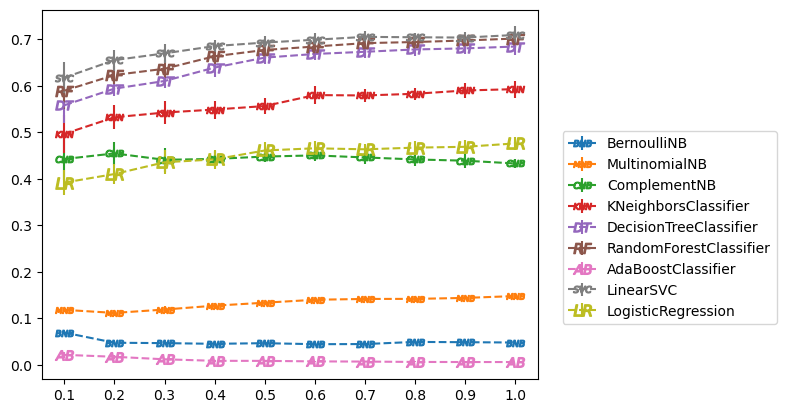

In [10]:
#Create Plots
metric = 'accuracy_balanced'

model_marker = {'sklearn.naive_bayes.BernoulliNB' : 'BNB',
                'sklearn.naive_bayes.MultinomialNB' : 'MNB',
                'sklearn.naive_bayes.ComplementNB' : 'CNB',
                'sklearn.svm._classes.LinearSVC' : 'SVC',
                'sklearn.neighbors._classification.KNeighborsClassifier' : 'KNN',
                'sklearn.linear_model._logistic.LogisticRegression' : 'LR',
                'sklearn.tree._classes.DecisionTreeClassifier' : 'DT',
                'sklearn.ensemble._forest.RandomForestClassifier' : 'RF',
                'sklearn.ensemble._weight_boosting.AdaBoostClassifier' : 'AB'}

model_name = {'sklearn.naive_bayes.BernoulliNB' : 'BernoulliNB',
              'sklearn.naive_bayes.MultinomialNB' : 'MultinomialNB',
              'sklearn.naive_bayes.ComplementNB' : 'ComplementNB',
              'sklearn.neighbors._classification.KNeighborsClassifier' : 'KNeighborsClassifier',
              'sklearn.tree._classes.DecisionTreeClassifier' : 'DecisionTreeClassifier',
              'sklearn.ensemble._forest.RandomForestClassifier' : 'RandomForestClassifier',
              'sklearn.ensemble._weight_boosting.AdaBoostClassifier' : 'AdaBoostClassifier',
              'sklearn.svm._classes.LinearSVC' : 'LinearSVC',
              'sklearn.linear_model._logistic.LogisticRegression' : 'LogisticRegression'}

model_order = ['sklearn.naive_bayes.BernoulliNB',
              'sklearn.naive_bayes.MultinomialNB',
              'sklearn.naive_bayes.ComplementNB',
              'sklearn.neighbors._classification.KNeighborsClassifier',
              'sklearn.tree._classes.DecisionTreeClassifier',
              'sklearn.ensemble._forest.RandomForestClassifier',
              'sklearn.ensemble._weight_boosting.AdaBoostClassifier',
              'sklearn.svm._classes.LinearSVC',
              'sklearn.linear_model._logistic.LogisticRegression']

model_colour = {'sklearn.naive_bayes.BernoulliNB' : 'tab:blue',
              'sklearn.naive_bayes.MultinomialNB' : 'tab:orange',
              'sklearn.naive_bayes.ComplementNB' : 'tab:green',
              'sklearn.neighbors._classification.KNeighborsClassifier' : 'tab:red',
              'sklearn.tree._classes.DecisionTreeClassifier' : 'tab:purple',
              'sklearn.ensemble._forest.RandomForestClassifier' : 'tab:brown',
              'sklearn.ensemble._weight_boosting.AdaBoostClassifier' : 'tab:pink',
              'sklearn.svm._classes.LinearSVC' : 'tab:gray',
              'sklearn.linear_model._logistic.LogisticRegression' : 'tab:olive'}


for m in model_order:
    
    x_values = []
    y_values = []
    deviation = []
    
    for f in pandas.Series.unique(dados.loc[(dados['model'] == m), 'size']):
        
        x_values.append(f)
        
        i = [float(x) for x in list(ast.literal_eval(dados.loc[(dados['model'] == m) & (dados['size'] == f), metric].item()))]
        
        y_values.append(statistics.mean(i))
        deviation.append(statistics.stdev(i))
        
        #print(x_values, y_values, deviation)
    plt.errorbar(x_values, y_values, yerr = deviation, fmt = '--', label = model_name[m], 
                 marker = '$' + model_marker[m] + '$', 
                 markersize=13, 
                 ecolor = model_colour[m])

plt.legend(loc = [1.05, 0.15])
plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
#plt.yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
#plt.ylim(-1, 1)

#plt.savefig(data_file + metric + '.svg', format = 'svg', dpi = 1200, bbox_inches = 'tight')
plt.show()


In [86]:
pandas.Series.unique(dados.loc[(dados['model'] == 'sklearn.naive_bayes.BernoulliNB'), 'size'])

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [ ]:
for x in list(pandas.Series.unique(dados.loc[:, 'model'])):
    print(x)

In [4]:
#t_metrics.to_csv(path_or_buf = 'cv_model1_tfidf_t_temp.csv', index= False)

In [11]:
#Import Dataset
data = pandas.read_csv(filepath_or_buffer = '5cv_model2_tfidf_tcnsw_0-5GDD_2grams.csv', sep = ',', header = 0) 

In [12]:
data['dataset'] = data['dataset'].apply(lambda x: 'publico')

In [13]:
data.head()

,model,size,dataset,accuracy,accuracy_balanced,recall_macro,precision_macro,recall_weighted,precision_weighted,f1_weighted,f1_macro,f1_micro,time,time_pred
0,sklearn.naive_bayes.BernoulliNB,0.5,publico,"['0.740', '0.745', '0.741', '0.742', '0.740']","['0.138', '0.140', '0.137', '0.136', '0.140']","['0.138', '0.140', '0.137', '0.136', '0.140']","['0.166', '0.166', '0.161', '0.160', '0.164']","['0.740', '0.745', '0.741', '0.742', '0.740']","['0.726', '0.730', '0.722', '0.721', '0.723']","['0.705', '0.710', '0.705', '0.707', '0.705']","['0.142', '0.144', '0.142', '0.141', '0.144']","['0.740', '0.745', '0.741', '0.742', '0.740']","['9.507', '8.279', '8.189', '8.289', '8.237']","['0.478', '0.526', '0.529', '0.525', '0.520']"
1,sklearn.naive_bayes.MultinomialNB,0.5,publico,"['0.771', '0.772', '0.769', '0.772', '0.771']","['0.286', '0.284', '0.284', '0.285', '0.289']","['0.286', '0.284', '0.284', '0.285', '0.289']","['0.325', '0.320', '0.316', '0.320', '0.324']","['0.771', '0.772', '0.769', '0.772', '0.771']","['0.758', '0.759', '0.754', '0.758', '0.760']","['0.741', '0.742', '0.737', '0.742', '0.741']","['0.296', '0.293', '0.292', '0.294', '0.298']","['0.771', '0.772', '0.769', '0.772', '0.771']","['8.268', '8.197', '8.155', '8.134', '8.204']","['0.444', '0.442', '0.435', '0.433', '0.433']"
2,sklearn.naive_bayes.ComplementNB,0.5,publico,"['0.820', '0.820', '0.818', '0.820', '0.820']","['0.735', '0.728', '0.734', '0.731', '0.741']","['0.734', '0.725', '0.733', '0.730', '0.739']","['0.771', '0.768', '0.774', '0.766', '0.781']","['0.820', '0.820', '0.818', '0.820', '0.820']","['0.913', '0.918', '0.907', '0.909', '0.917']","['0.825', '0.826', '0.823', '0.825', '0.825']","['0.738', '0.733', '0.741', '0.734', '0.746']","['0.820', '0.820', '0.818', '0.820', '0.820']","['8.259', '8.261', '8.269', '8.312', '8.330']","['0.298', '0.300', '0.309', '0.303', '0.302']"
3,sklearn.neighbors._classification.KNeighborsCl...,0.5,publico,"['0.890', '0.892', '0.827', '0.893', '0.829']","['0.736', '0.726', '0.729', '0.751', '0.743']","['0.735', '0.724', '0.728', '0.749', '0.742']","['0.771', '0.765', '0.773', '0.788', '0.786']","['0.890', '0.892', '0.827', '0.893', '0.829']","['0.882', '0.883', '0.891', '0.883', '0.907']","['0.869', '0.871', '0.835', '0.872', '0.838']","['0.742', '0.733', '0.739', '0.758', '0.752']","['0.890', '0.892', '0.827', '0.893', '0.829']","['0.536', '0.518', '0.534', '0.526', '0.559']","['337.080', '329.268', '355.384', '341.101', '..."
4,sklearn.tree._classes.DecisionTreeClassifier,0.5,publico,"['0.893', '0.895', '0.895', '0.895', '0.894']","['0.780', '0.765', '0.771', '0.780', '0.782']","['0.780', '0.763', '0.770', '0.779', '0.782']","['0.821', '0.804', '0.812', '0.814', '0.821']","['0.893', '0.895', '0.895', '0.895', '0.894']","['0.889', '0.890', '0.884', '0.884', '0.891']","['0.871', '0.874', '0.873', '0.873', '0.873']","['0.788', '0.772', '0.780', '0.786', '0.789']","['0.893', '0.895', '0.895', '0.895', '0.894']","['17.729', '18.236', '17.938', '17.479', '17.5...","['0.294', '0.298', '0.304', '0.293', '0.302']"


In [15]:
#data.to_csv(path_or_buf = '5cv_model2_tfidf_tcnsw_0-5GDD_2grams.csv', index= False)